# RNN Based molucule generation

Laurent Cetinsoy

In this hands-on we want to generate molecule formulas for denovo-drug discovery.

For that we need to use Generative models. Generative models are models which goes beyond classification or simple regression : they are able to generate data that look like previously seens dataset.

There exists a lot of models :

- Bayesian models like graphical models
- Recurrent models (for sequence generation like texte)
- Variational auto encoders
- Generative adversarial models
- Flow and diffusion models


In the hands-on we will start by  trainning a character based RNN to generate smile molecules


We want to feed smile representations of molecules to an RNN.
The basic idea is we will train it to predict the next smile token of a molecule given the previous one.

For instance for the following molecule "CC(=O)NC1=CC=C(O)C=C1" will may give to the model

X = "CC(=O)N"
y = C

and ask the RNN to learn to predict y given X

Like a standard language model !


## RNN Language model


A language model is a model which predict the next token of a sequence given the previous ones :

$ P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p})  $


This model can be learned with a Recurrent neural network

$ y = P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p}) = RNN_{\theta} (X_{t-1}, X_{t-2}, ..., X_{t-p})  $


In order to train such model you need a corpus of data.



There are two main ways to do that : Word level model or character level model

For character level models, an interesting resource is : http://karpathy.github.io/2015/05/21/rnn-effectiveness/



Explain briefly what is the difference between word based language model and character based language model

## Loading the data

Dowload the following dataset : https://github.com/joeymach/Leveraging-VAE-to-generate-molecules

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint
import os

Import pandas and load the first 1000 lines

In [ ]:
data_path = '/content/250k_smiles.csv'  # Remplacer par le chemin de votre dataset
df = pd.read_csv(data_path).head(1000)  # Charger les 1000 premières lignes

Display the first rows of the dataframe

In [ ]:
print(df.head())

                                              smiles     logP       qed  \
0          CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n  5.05060  0.702012   
1     C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n  3.11370  0.928975   
2  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...  4.96778  0.599682   
3  CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...  4.00022  0.690944   
4  N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...  3.60956  0.789027   

        SAS  
0  2.084095  
1  3.432004  
2  2.470633  
3  2.822753  
4  4.035182  


## Processing the data

We need to do the following things :

- convert smile tokens to numbers
- build  smile token sequences and corresponding labels pairs

Compute the biggest smile molecule size

In [ ]:
# prompt: Compute the biggest smile molecule size

# Compute the biggest smile molecule size
max_len = df['smiles'].str.len().max()
print(f"The biggest smile molecule size is: {max_len}")

The biggest smile molecule size is: 106



Code a function **unic_characters(string)** which return the unic characters in a string


In [ ]:
def unic_characters(string):
    """Retourne les caractères uniques dans une chaîne."""
    return sorted(set(string))

Concatenate all smile string of the pandas dataframe and use **unic_characters** to get the unic_characters

In [ ]:
# Concaténer toutes les SMILES
all_smiles = ''.join(df['smiles'].tolist())
unique_chars = unic_characters(all_smiles)

Code a function **map_char_to_int(unic_chars)** which returns a dictionnary where each char is assigned an int value.
Add a character to specify the end of the molecule (like "\n")


In [ ]:
def map_char_to_int(unic_chars):
    """Mappe chaque caractère unique à un entier."""
    return {char: idx for idx, char in enumerate(unic_chars + ['\n'])}

Code a function map_int_to_char(unic_chars) which returns the reverse mapping.

If you want you can merge both functions in a class

In [ ]:
def map_int_to_char(unic_chars):
    """Mappe chaque entier à son caractère correspondant."""
    return {idx: char for idx, char in enumerate(unic_chars + ['\n'])}

For each smile molecule add the ending token to it

In [ ]:
char_to_int = map_char_to_int(unique_chars)
int_to_char = map_int_to_char(unique_chars)

df['smiles'] = df['smiles'] + '\n'

## Building the dataset

Now we will create the dataset so that it has the good share for our Keras LSTM model

Remember Keras recurrent models expect a 3D array with shapes (n_examples, seq_len, n_features)



What will be n_features in our case ?

**REPONSE : Dans notre cas, n_features est le nombre de caractères uniques dans les molécules SMILES, plus le caractère de fin ajouté ("\n")**

Code a function **build_X_and_y(string, i_char, seq_lenght)** which takes a string, a **seq_length** number and a position.


It should create X by by getting all character between i and i + seq_length
and create y by getting the character following the X sequence
it returns X and y

Test your function on the following string "" with seq_length = 4 and i = [1, 2, 3]

In [ ]:
def build_X_and_y(string, i_char, seq_length):
    """Construit les séquences X et les étiquettes y pour un index donné."""
    X = string[i_char : i_char + seq_length]  # Séquence de caractères
    y = string[i_char + seq_length]          # Caractère suivant
    return X, y

# Test de la fonction
test_string = "CC(=O)NC1=CC=C(O)C=C1\n"
seq_length = 4
for i in [1, 2, 3]:
    X, y = build_X_and_y(test_string, i, seq_length)
    print(f"i={i}, X={X}, y={y}")


By using build_X_and_y and map_char_to_int build a list nameed X_train and a list named y_train

In [ ]:
# Ajouter un caractère de fin à chaque molécule
df['smiles'] = df['smiles'].str.strip() + '\n'

# Initialiser les listes X_train et y_train
X_train = []
y_train = []

# Construire les paires X et y
seq_length = 10  # Longueur des séquences
for smile in df['smiles']:
    for i in range(len(smile) - seq_length):
        X, y = build_X_and_y(smile, i, seq_length)
        X_train.append([char_to_int[char] for char in X])  # Convertir X en entiers
        y_train.append(char_to_int[y])  # Convertir y en entier

print(f"Nombre de séquences dans X_train : {len(X_train)}")
print(f"Nombre de labels dans y_train : {len(y_train)}")


Nombre de séquences dans X_train : 35242
Nombre de labels dans y_train : 35242


Create numpy arrays from the lists

In [ ]:
import numpy as np

# Conversion des listes en tableaux numpy
X_train = np.array(X_train)
y_train = np.array(y_train)

# Afficher les dimensions des tableaux
print(f"Dimensions de X_train : {X_train.shape}")
print(f"Dimensions de y_train : {y_train.shape}")


Dimensions de X_train : (35242, 10)
Dimensions de y_train : (35242,)


Reshape the X numpy array (n_examples, seq_lenght, 1)

In [ ]:
# Reshape X_train
X_train_reshaped = X_train.reshape(X_train.shape[0], seq_length, 1)

# Afficher les dimensions après le reshape
print(f"Dimensions de X_train après reshape : {X_train_reshaped.shape}")

Dimensions de X_train après reshape : (35242, 10, 1)


Normalize X by dividing each values by the total number of unic characters

In [ ]:
# Normalisation des données
X_train_normalized = X_train_reshaped / len(unique_chars)

# Afficher les dimensions du tableau normalisé
print(f"Dimensions de X_train après normalisation : {X_train_normalized.shape}")

Dimensions de X_train après normalisation : (35242, 10, 1)


Import Keras and build (at least) a two layered LSTM network with 128 neurone in each.

You can also add Dropoutlayers

Do you think you should use the return_sequences = True ? If yes, when ?


Add a Dense layer on top with with the appropriate activation function and number of neurones


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Construction du modèle
model = Sequential([
    # Première couche LSTM
    # return_sequences=True car nous avons une deuxième couche LSTM
    LSTM(128, input_shape=(10, 1), return_sequences=True),
    Dropout(0.2),  # Couche de dropout pour réduire le surapprentissage

    # Deuxième couche LSTM
    # return_sequences=False car c'est la dernière couche LSTM
    LSTM(128),
    Dropout(0.2),

    # Couche Dense de sortie
    # nombre de neurones = nombre de caractères uniques
    # activation='softmax' car c'est un problème de classification multi-classes
    Dense(len(char_to_int), activation='softmax')
])

# Affichage du résumé du modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 10, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 33)                  │           4,257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,401 (790.63 KB)

 Trainable params: 202,401 (790.63 KB)

 Non-trainable params: 0 (0.00 B)

Compile the model with the appropriate loss function and the adam optimizer

In [ ]:
# Compilation du modèle
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Train the model on 20 epochs and 10 examples (yeah you read correctly) and check that the model overfits !

In [ ]:
# Entraînement sur un petit ensemble pour vérifier le surapprentissage
# Sélection de 10 exemples aléatoires
indices = np.random.choice(len(X_train_normalized), 10)
X_small = X_train_normalized[indices]
y_small = y_train[indices]

# Entraînement sur 20 époques
history = model.fit(X_small, y_small,
                   epochs=20,
                   batch_size=1,
                   verbose=1)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1916 - loss: 3.4575
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1324 - loss: 3.1913
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3795 - loss: 2.4808
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1669 - loss: 2.5295
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5176 - loss: 1.9043
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3563 - loss: 1.8389
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1206 - loss: 2.3081
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5231 - loss: 1.8700
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4821 - loss: 1.5418
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2646 - loss: 1.9640
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4915 - loss: 1.7923
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy:

If it does not overfit try to fix data prep and model architecture so it does

Create a function **make_prediction(seed_start)** which takes a starting string sequence and uses it to generate a molecule


In [ ]:
def make_prediction(seed_start, max_length=100):
    """
    Génère une molécule à partir d'une séquence de départ

    Args:
        seed_start (str): Séquence de départ
        max_length (int): Longueur maximum de la molécule générée

    Returns:
        str: Molécule générée
    """
    generated = seed_start

    # Padding de la séquence initiale si nécessaire
    if len(generated) < 10:
        # On ajoute des 'C' au début jusqu'à avoir 10 caractères
        generated = 'C' * (10 - len(generated)) + generated

    while len(generated) < max_length:
        # Préparation de la séquence d'entrée
        x = generated[-10:]  # Prendre les 10 derniers caractères
        x = np.array([char_to_int[char] for char in x])
        x = x.reshape(1, 10, 1)
        x = x / len(char_to_int)

        # Prédiction
        pred = model.predict(x, verbose=0)[0]
        next_char_idx = np.argmax(pred)
        next_char = int_to_char[next_char_idx]

        # Arrêt si on prédit le caractère de fin
        if next_char == '\n':
            break

        generated += next_char

    # On retourne seulement la partie après le padding initial
    return generated[10-len(seed_start):]



generate a molecule of your overfitted model

In [ ]:
seed = "CC"
generated_molecule = make_prediction(seed)
print(f"Molécule générée: {generated_molecule}")

Molécule générée: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


Make a model checkpoint so that the model is saved after each epoch
if you train on a plateform and it stops you do not lose your training

In [ ]:
# Créer un ModelCheckpoint callback avec .keras à la fin
checkpoint_path = "/content/LSTM_Model_checkpoint.keras"  # Changer le .h5 en .keras

# Créer un ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',  # Surveiller la validation
                             save_best_only=True,  # Sauvegarder seulement les meilleurs modèles
                             save_weights_only=False,
                             verbose=1)

Now go to your favorite plateform (colab or something else) and train the dataset on the whole data for 10 epochs and batch size 256

it should take a long time so either follow the class or go take a nap

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.1837 - loss: 2.9715
Epoch 1: val_loss improved from inf to 2.70687, saving model to /content/LSTM_Model_checkpoint.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.1837 - loss: 2.9700 - val_accuracy: 0.1733 - val_loss: 2.7069
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1982 - loss: 2.6839
Epoch 2: val_loss improved from 2.70687 to 2.67647, saving model to /content/LSTM_Model_checkpoint.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.1982 - loss: 2.6839 - val_accuracy: 0.1915 - val_loss: 2.6765
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2086 - loss: 2.6494
Epoch 3: val_loss improved from 2.67647 to 2.58612, saving model to /content/LSTM_Model_checkpoint.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.2087 - loss: 2.6492 - val_accuracy: 0.2037 - val_loss: 2.5861
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2345

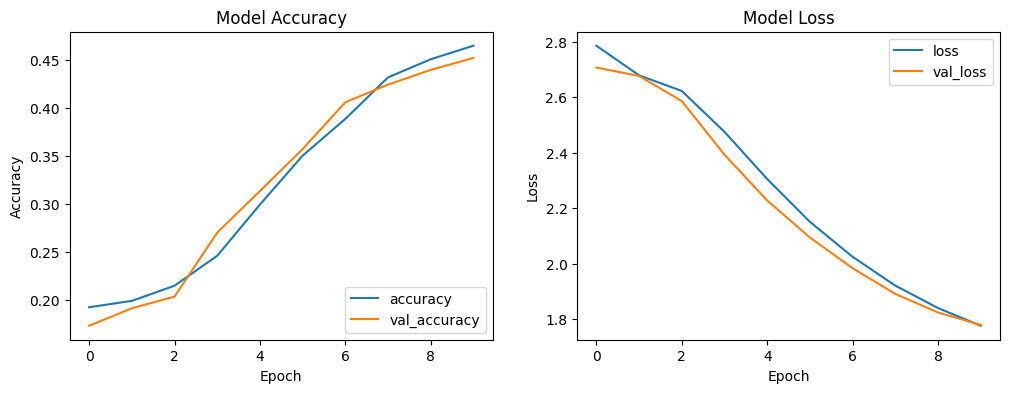

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Définir le modèle LSTM
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_normalized.shape[1], 1)),
    LSTM(64),
    Dense(34, activation='softmax')  # Assurez-vous que le nombre de sorties correspond aux classes (34 dans ce cas)
])

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrainer le modèle sur 10 epochs avec un batch_size de 256
history = model.fit(X_train_normalized, y_train_encoded,
                    epochs=10,
                    batch_size=256,
                    validation_split=0.1,
                    callbacks=[checkpoint],
                    verbose=1)

# Visualisation des résultats d'entraînement
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


Generate between 100 and 1000 molecules.

create a list where molecules have between 10 and 50 atoms

In [ ]:
import numpy as np

# Function to generate multiple molecules
def generate_molecules(num_molecules=1000, min_atoms=10, max_atoms=50):
    generated_molecules = []

    while len(generated_molecules) < num_molecules:
        seed = "CC"  # Starting seed
        molecule = make_prediction(seed, max_length=max_atoms)

        # Check if molecule length (excluding padding) is within the desired range
        if min_atoms <= len(molecule.strip()) <= max_atoms:
            generated_molecules.append(molecule.strip())  # Remove padding and add to the list

    return generated_molecules

# Generate molecules
molecules = generate_molecules(1000, 10, 50)

# Output the number of molecules generated
print(f"Total molecules generated: {len(molecules)}")


Total molecules generated: 1000


With rdkit compute the Quantified Estimated Drug likelyness (QED) of each molecule in this subset

In [7]:
!pip install rdkit

from rdkit import Chem
from rdkit.Chem import QED
import numpy as np

# Function to compute QED for each molecule
def compute_qed(molecules):
    qed_values = []

    for mol in molecules:
        # Convert the SMILES string to an RDKit molecule object
        mol_obj = Chem.MolFromSmiles(mol)
        if mol_obj is not None:
            # Compute the QED
            qed = QED.qed(mol_obj)
            qed_values.append(qed)
        else:
            qed_values.append(None)  # If molecule is invalid or cannot be processed, return None

    return qed_values

# Generate molecules (from previous example)
molecules = generate_molecules(1000, 10, 50)

# Compute QED for each molecule in the subset
qed_values = compute_qed(molecules)

# Output the QED values and some statistics
print(f"Total molecules generated: {len(molecules)}")
print(f"QED values computed: {len(qed_values)}")
print(f"Mean QED: {np.mean([q for q in qed_values if q is not None]):.3f}")
print(f"Median QED: {np.median([q for q in qed_values if q is not None]):.3f}")
print(f"Number of molecules with valid QED values: {len([q for q in qed_values if q is not None])}")

# Optionally, print some QED values for inspection
print("Sample QED values:")
for mol, qed in zip(molecules[:10], qed_values[:10]):
    print(f"Molecule: {mol[:30]}... QED: {qed:.3f}")


Total molecules generated: 1000
QED values computed: 1000
Mean QED: 0.385
Median QED: 0.384
Number of molecules with valid QED values: 1000
Sample QED values:
Molecule: CCO... QED: 0.407
Molecule: CCN... QED: 0.406
Molecule: CCC... QED: 0.385
Molecule: CCCl... QED: 0.372
Molecule: CNC... QED: 0.399
Molecule: COC... QED: 0.380
Molecule: C=C... QED: 0.344
Molecule: CCF... QED: 0.382
Molecule: CCBr... QED: 0.412
Molecule: CNO... QED: 0.364


Bonus 1 : Using rdkit, compute the quantitative estimation of drug-likeness (QED) of your generated molecules.

Bonus 2 : try to adapt a transformer model training from hugging face to see if it is better